In [113]:
import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy.interpolate import griddata, interp2d
import pickle
import os


import astropy as ap
from astropy.io import fits
from astropy import table as t
from astropy.table import Table
from astropy import wcs
from astropy.cosmology import WMAP7

import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from matplotlib import rcParams
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc
from matplotlib import colors
from matplotlib.colors import LogNorm

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 22
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titlesize'] = 17
rcParams['xtick.labelsize'] = 17
rcParams['ytick.labelsize'] = 17
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 1

In [2]:
os.chdir("/Users/nitya/Work/data/Project2")
drpall = t.Table.read('drpall-v2_5_3.fits')
print(len(drpall))
drpall.add_index('plateifu')
index1 = np.where(drpall['srvymode']=='MaNGA dither')[0]
drpall1 = drpall[index1]
index2 = np.where(drpall1['z']>0)[0]
drpall = drpall1[index2]
index3 = np.where(drpall['nsa_z']>0)[0]
drpall = drpall[index3]

#print(drpall.columns)
print(len(drpall))

a = pickle.load(open(r'manga_4000_hdelta_dn4000.pkl','rb'), encoding = 'latin1')
a = a[index3]
print(a.dtype.names)

d1 = pickle.load(open(r'shifted_z_0.02','rb'), encoding = 'latin1') 
d2 = pickle.load(open(r'shifted_z_0.04','rb'), encoding = 'latin1')
d3 = pickle.load(open(r'shifted_z_0.06','rb'), encoding = 'latin1')
d4a = pickle.load(open(r'shifted_z_0.08','rb'), encoding = 'latin1')
d5 = pickle.load(open(r'shifted_z_0.1','rb'), encoding = 'latin1')
d6 = pickle.load(open(r'shifted_z_0.14','rb'), encoding = 'latin1')

6779
6468
('plate_ifu', 'z', 'hdelta_all', 'hdelta_3', 'hdelta_5', 'hdelta_7', 'dn4000_all', 'dn4000_3', 'dn4000_5', 'dn4000_7')


In [3]:
df = pd.read_csv('hd_d4000_mlratio_z.csv')
df.head()

,Unnamed: 0,specObjID,plateid_x,mjd_x,targettype_x,z_x,ra_x,dec_x,spectrotype_x,lick_hd_a,...,spectrotype_y,psfFlux_z,fiberFlux_z,modelMag_z,fiberMag_z,petroMag_z,psfMag_z,cModelMag_z,zband_lum,mlratio_z
0,1288098,571978357969807360,508,52366,GALAXY,0.065824,166.4783,2.094602,GALAXY,2.151605,...,GALAXY,28.06302,33.45266,16.86503,18.68839,16.92087,18.87891,16.92317,9.759862,0.189329
1,400208,1562851102729201664,1388,53119,GALAXY,0.111108,232.1581,32.259860,GALAXY,2.135609,...,GALAXY,68.12619,89.96645,15.89000,17.61473,15.95821,17.91659,15.79503,10.615238,0.347252
2,590268,2187701916006377472,1943,53386,GALAXY,0.061661,142.9699,32.348130,GALAXY,3.941239,...,GALAXY,42.61896,50.59392,17.25803,18.23952,17.33761,18.42566,17.28630,9.512923,0.006772
3,989578,487552899115673600,433,51873,GALAXY,0.106914,116.2391,37.233990,GALAXY,2.766207,...,GALAXY,26.55329,39.21035,16.65694,18.51611,16.68685,18.93886,16.56544,10.268623,-0.021323
4,169894,1130466224317163520,1004,52723,GALAXY,0.045666,167.0256,6.661255,GALAXY,2.404512,...,GALAXY,66.11886,75.75258,16.86960,17.80140,16.82482,17.94905,16.68491,9.409395,0.201458


In [4]:
mlz_model = df['mlratio_z'].values
hda_model = df['lick_hd_a_model'].values
d4_model = df['d4000_n_model'].values
model_grid = np.column_stack((np.array(d4_model), np.array(hda_model)))
#points2 = np.column_stack((np.array(d4_model[0:10]), np.array(hda_model[0:10])))
#mlz_new =griddata(points1,np.array(mlz),points2, method = 'linear')

In [92]:
def all_measures(array,z):
    
    hd = np.array([array[i][2][0] for i in range(len(array))])
    d4 = np.array([array[i][2][1] for i in range(len(array))])
    b = a[~np.isnan(hd)]
    hd_all = b['hdelta_all']
    b = b[hd_all>-10]
    
    #at that redshift
    hd_z = hd[~np.isnan(hd)][hd_all>-10]
    d4_z = d4[~np.isnan(hd)][hd_all>-10]
    
    #Offsets
    offz_d4 = np.array([b['dn4000_all'][i]- d4_z[i] for i in range(len(d4_z))])
    offz_hd = np.array([b['hdelta_all'][i]- hd_z[i] for i in range(len(d4_z))])
    
    #Interpolating to get the M/L ratios at z and the total M/L ratios
    points_z = np.column_stack((d4_z,hd_z))
    points_all = np.column_stack((b['dn4000_all'], b['hdelta_all']))
    mlz_z = griddata(model_grid,np.array(mlz_model),points_z, method = 'nearest')
    mlz_all = griddata(model_grid,np.array(mlz_model),points_all, method = 'nearest')
    mlz_offset = np.array([mlz_all[i]- mlz_z[i] for i in range(len(mlz_z))])

    #Make a pandas dataframe and write to it
    data = {'plate_ifu': b['plate_ifu'], 'z': b['z'], 
            'hd_z': hd_z, 'd4_z': d4_z,
            'hd_all': b['hdelta_all'], 'd4_all': b['dn4000_all'], 
            'offset_hd': offz_hd, 'offset_d4': offz_d4, 
            'mlz_z': mlz_z, 'mlz_all': mlz_all, 'offset_mlz': mlz_offset
            }
    d = pd.DataFrame(data=data)
    filepath = '/Users/nitya/Work/data/Project2/offset_mlratio_nearest_'+str(z)+'.csv'
    d.to_csv(filepath)
    
    return d

In [107]:
c3 = all_measures(d1,0.02)

In [108]:
len(c3[np.isnan(c3['mlz_z'])==True])

0

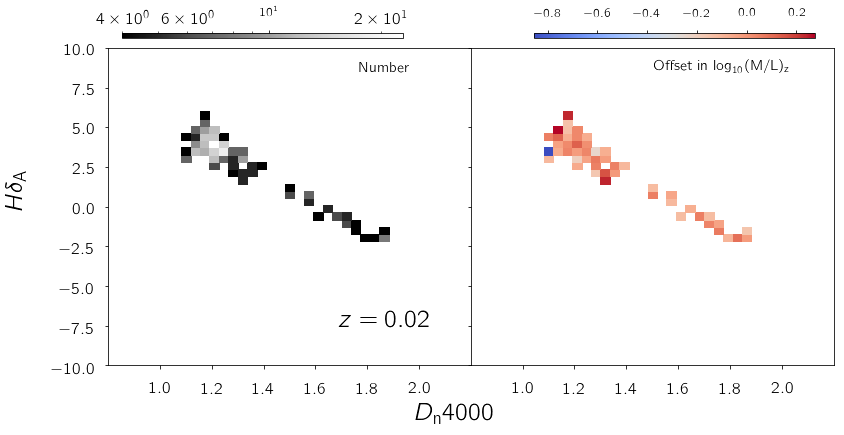

In [111]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13,7))
t1 = binned_statistic_2d(c3['d4_z'], c3['hd_z'],c3['offset_mlz'],statistic = 'mean',bins=(30,30))
tcount = binned_statistic_2d(c3['d4_z'], c3['hd_z'],c3['mlz_z'],statistic = 'count',bins=(30,30))
yedges1 = t1[1]
xedges1 = t1[2]
number = np.ma.array(tcount[0], mask = tcount[0] <= 3)
mass = np.ma.array(t1[0], mask = tcount[0] <= 3)

cs1 = ax1.pcolormesh(yedges1,xedges1,np.transpose(number), cmap = plt.cm.Greys_r, norm = LogNorm())
ax1.set_xticks([1.0,1.2,1.4,1.6,1.8,2.0])
ax1.set_xlim(0.8,2.2)
ax1.set_ylim(-10,10)

cs2 = ax2.pcolormesh(yedges1,xedges1,(np.transpose(mass)), cmap = plt.cm.coolwarm)
ax2.set_xticks([1.0,1.2,1.4,1.6,1.8,2.0])
ax2.yaxis.set_ticklabels([])
ax2.set_xlim(0.8,2.2)
ax2.set_ylim(-10,10)

cbar_ax1 = fig.add_axes([0.14, 0.85, 0.3, 0.01])
cb1 = fig.colorbar(cs1,orientation = 'horizontal', cax=cbar_ax1)
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.tick_params(labelsize=13)
cbar_ax2 = fig.add_axes([0.58, 0.85, 0.3, 0.01])
cb2 = fig.colorbar(cs2,orientation = 'horizontal', cax=cbar_ax2)
cb2.ax.xaxis.set_ticks_position('top')
cb2.ax.tick_params(labelsize=13)

fig.text(0.78, 0.79, r'Offset in ${\rm log}_{10}(\rm M/L)_{z}$',
         ha='center', va='center', fontsize = 15)
fig.text(0.42, 0.79, 'Number',
         ha='center', va='center', fontsize = 15)
fig.text(0.42, 0.29, r'$z=0.02$',
         ha='center', va='center', fontsize = 25)
fig.text(0.495, 0.1, r'$D_{\rm n}4000$', 
         ha='center', va='center', fontsize = 25)
fig.text(0.03, 0.55, r'$H\delta_{\rm A}$', 
          rotation=90, ha='center', va='center', fontsize = 25)

plt.gcf().subplots_adjust(wspace=0, hspace = 0, top = 0.83, bottom = 0.2)
plt.savefig('/Users/Nitya/Desktop/mlz_offset_0.02.pdf')
plt.show()

In [5]:
hdoff = binned_statistic_2d(c3[0],c3[1],c3[3],statistic = 'mean',bins=(yedges1,xedges1))
d4off = binned_statistic_2d(c3[0],c3[1],c3[2],statistic = 'mean',bins=(yedges1,xedges1))
tcount = binned_statistic_2d(c3[0],c3[1],c3[0],statistic = 'count',bins=(yedges1,xedges1))
yedges = [0.5*(tcount[1][i] + tcount[1][i+1]) for i in range(20)]
xedges = [0.5*(tcount[2][i] + tcount[2][i+1]) for i in range(20)]
hd_offset = np.ma.array(hdoff[0], mask = tcount[0] <= 3)
d4_offset = np.ma.array(d4off[0], mask = tcount[0] <= 3)

fig, ax = plt.subplots(figsize = (8,9))
q = ax.quiver(yedges, xedges, np.transpose(d4_offset), np.transpose(hd_offset), 
              angles = 'xy', scale = 1., scale_units = 'xy')
ax.grid()
ax.set_xlim(0.8,2.2)
ax.set_ylim(-5.0,8.0)
ax.set_xlabel(r'$D_{n}4000$',)
ax.set_ylabel(r'$H_{\delta_{A}}$')

filename = "quiver_c.pdf"
#plt.gcf().subplots_adjust(wspace=0, hspace = 0, top = 0.83)
fig.text(0.66, 0.79, r'$z = 0.14$',
         ha='center', va='center', fontsize = 25)
plt.savefig(filename)
plt.show()

In [6]:
b1 = all_measures(d1,0.02)
b2 = all_measures(d3,0.06)
b3 = all_measures(d6,0.14)
c1 = all_offsets(d1,0.02)
c2 = all_offsets(d3,0.06)
c3 = all_offsets(d6,0.14)

561
5016
6402
561
5016
6402


In [8]:

d4_z1,hd_z1,offz_d4,offz_hd = all_offsets(d1,0.06)

Index(['Unnamed: 0', 'specObjID', 'plateid_x', 'mjd_x', 'targettype_x', 'z_x',
       'ra_x', 'dec_x', 'spectrotype_x', 'lick_hd_a', 'lick_hd_a_err',
       'lick_hd_a_model', 'lick_hd_a_sub', 'lick_hd_a_sub_err', 'd4000_n',
       'd4000_n_err', 'd4000_n_model', 'd4000_n_sub', 'd4000_n_sub_err',
       'lgm_tot_p50', 'sfr_tot_p50', 'plateid_y', 'mjd_y', 'targettype_y',
       'z_y', 'ra_y', 'dec_y', 'spectrotype_y', 'psfFlux_z', 'fiberFlux_z',
       'modelMag_z', 'fiberMag_z', 'petroMag_z', 'psfMag_z', 'cModelMag_z',
       'zband_lum', 'mlratio_z'],
      dtype='object')

In [ ]:

t1 = binned_statistic_2d(d['d4000_n_model'], d['lick_hd_a_model'], 
                         d['mlratio_z'],statistic = 'mean',bins=(50,50))
tcount = binned_statistic_2d(d['d4000_n_model'], d['lick_hd_a_model'],
                             d['mlratio_z'],statistic = 'count',bins=(50,50))

ybins = np.array(t1[1])
xbins = np.array(t1[2])
#print(ybins,xbins)

-1.509684472277275 1.5784072608958346
0.11367860976402012 1.4450086300204876
-0.496756615457184 1.9311220310071926
0.10843146995806621 1.9355298785304569
-1.0589358912352063 1.580564207372424
0.053026668147269355 2.9521878412391107


/Users/nitya/miniconda3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/nitya/miniconda3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/nitya/miniconda3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the

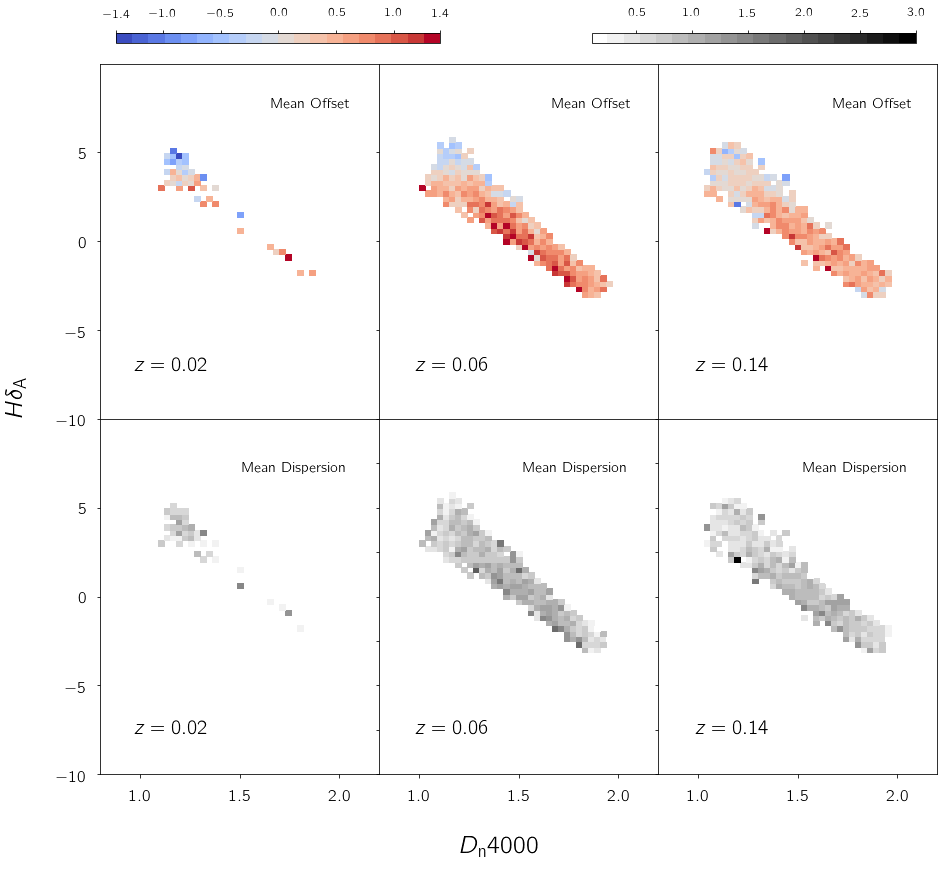

In [11]:
fig, ax = plt.subplots(2, 3, figsize = (15,14))

bounds2 = np.linspace(-1.4, 1.4, 21)
norm2 = colors.BoundaryNorm(boundaries=bounds2, ncolors=256)
bounds1 = np.linspace(0.1, 3, 21)
norm1 = colors.BoundaryNorm(boundaries=bounds1, ncolors=256)
#norm1 = colors.LogNorm(0.1,3)

t1 = binned_statistic_2d(c1[0],c1[1],c1[3],statistic = 'mean',bins=(ybins,xbins))
tcount = binned_statistic_2d(c1[0],c1[1],c1[3],statistic = 'count',bins=(ybins,xbins))
yedges1 = t1[1]
xedges1 = t1[2]
number = np.ma.array(t1[0], mask = tcount[0] <= 3)
print(np.min(number), np.max(number))
cs1 = ax[0,0].pcolormesh(yedges1,xedges1,(np.transpose(number)),cmap = plt.cm.coolwarm, norm = norm2)
#fig.colorbar(cs1, ax = ax[0])
ax[0,0].set_xlim(0.8,2.2)
ax[0,0].set_ylim(-10,10)
ax[0,0].set_xticks([1.0,1.5,2.0])
ax[0,0].xaxis.set_ticklabels([])
ax[0,0].yaxis.set_ticks([-10,-5,0,5])
t2 = binned_statistic_2d(c1[0],c1[1],c1[3],statistic = np.std,bins=(ybins,xbins))
yedges2 = t2[1]
xedges2 = t2[2]
number = np.ma.array(t2[0], mask = tcount[0] <= 3)
print(np.min(number), np.max(number))
cs2 = ax[1,0].pcolormesh(yedges2,xedges2,(np.transpose(number)),cmap = plt.cm.binary, norm = norm1)
ax[1,0].set_xlim(0.8,2.2)
ax[1,0].set_ylim(-10,10)
ax[1,0].set_xticks([1.0,1.5,2.0])
ax[1,0].yaxis.set_ticks([-10,-5,0,5])

t1 = binned_statistic_2d(c2[0],c2[1],c2[3],statistic = 'mean',bins=(ybins,xbins))
tcount = binned_statistic_2d(c2[0],c2[1],c2[3],statistic = 'count',bins=(ybins,xbins))
number = np.ma.array(t1[0], mask = tcount[0] <= 3)
print(np.min(number), np.max(number))
cs1 = ax[0,1].pcolormesh(yedges1,xedges1,(np.transpose(number)),cmap = plt.cm.coolwarm, norm = norm2)
ax[0,1].set_xlim(0.8,2.2)
ax[0,1].set_ylim(-10,10)
ax[0,1].set_xticks([1.0,1.5,2.0])
ax[0,1].set_yticks([-10,-5,0,5])
ax[0,1].xaxis.set_ticklabels([])
ax[0,1].yaxis.set_ticklabels([])
t2 = binned_statistic_2d(c2[0],c2[1],c2[3],statistic =np.std,bins=(yedges2,xedges2))
number = np.ma.array(t2[0], mask = tcount[0] <= 3)
print(np.min(number), np.max(number))
cs2 = ax[1,1].pcolormesh(yedges2,xedges2,(np.transpose(number)),cmap = plt.cm.binary, norm = norm1)
ax[1,1].set_xlim(0.8,2.2)
ax[1,1].set_ylim(-10,10)
ax[1,1].set_xticks([1.0,1.5,2.0])
ax[1,1].yaxis.set_ticklabels([])

t1 = binned_statistic_2d(c3[0],c3[1],c3[3],statistic = 'mean',bins=(ybins,xbins))
tcount = binned_statistic_2d(c3[0],c3[1],c3[3],statistic = 'count',bins=(ybins,xbins))
number = np.ma.array(t1[0], mask = tcount[0] <= 3)
print(np.min(number), np.max(number))
cs1 = ax[0,2].pcolormesh(yedges1,xedges1,(np.transpose(number)),cmap = plt.cm.coolwarm, norm =norm2)
ax[0,2].set_xlim(0.8,2.2)
ax[0,2].set_ylim(-10,10)
ax[0,2].set_yticks([-10,-5,0,5])
ax[0,2].set_xticks([1.0,1.5,2.0])
ax[0,2].yaxis.set_ticklabels([])
t2 = binned_statistic_2d(c3[0],c3[1],c3[3],statistic = np.std,bins=(ybins,xbins))
number = np.ma.array(t2[0], mask = tcount[0] <= 3)
print(np.min(number), np.max(number))
cs2 = ax[1,2].pcolormesh(yedges2,xedges2,(np.transpose(number)),cmap = plt.cm.binary, norm = norm1)
ax[1,2].set_xlim(0.8,2.2)
ax[1,2].set_ylim(-10,10)
ax[1,2].yaxis.set_ticklabels([])

cbar_ax1 = fig.add_axes([0.14, 0.85, 0.3, 0.01])
cb1 = fig.colorbar(cs1,orientation = 'horizontal', cax=cbar_ax1)
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.tick_params(labelsize=13)
cb1.set_clim(-1.4,1.4)
cb1.set_ticks([-1.4,-1,-0.5,0,0.5,1,1.4])

cbar_ax2 = fig.add_axes([0.58, 0.85, 0.3, 0.01])
cb2 = fig.colorbar(cs2,orientation = 'horizontal', cax=cbar_ax2)
cb2.ax.xaxis.set_ticks_position('top')
cb2.ax.tick_params(labelsize=13)
cb2.set_ticks([0.5,1,1.5,2.0,2.5,3.0])

fig.text(0.32, 0.79, 'Mean Offset',
         ha='center', va='center', fontsize = 15)
fig.text(0.58, 0.79, 'Mean Offset',
         ha='center', va='center', fontsize = 15)
fig.text(0.84, 0.79, r'Mean Offset',
         ha='center', va='center', fontsize = 15)

fig.text(0.305, 0.43, 'Mean Dispersion',
         ha='center', va='center', fontsize = 15)
fig.text(0.565, 0.43, 'Mean Dispersion',
         ha='center', va='center', fontsize = 15)
fig.text(0.825, 0.43, r'Mean Dispersion',
         ha='center', va='center', fontsize = 15)

fig.text(0.19, 0.53, r'$z = 0.02$',
         ha='center', va='center', fontsize = 20)
fig.text(0.45, 0.53, r'$z = 0.06$',
         ha='center', va='center', fontsize = 20)
fig.text(0.71, 0.53, r'$z = 0.14$',
         ha='center', va='center', fontsize = 20)

fig.text(0.19, 0.17, r'$z = 0.02$',
         ha='center', va='center', fontsize = 20)
fig.text(0.45, 0.17, r'$z = 0.06$',
         ha='center', va='center', fontsize = 20)
fig.text(0.71, 0.17, r'$z = 0.14$',
         ha='center', va='center', fontsize = 20)

fig.text(0.495, 0.05, r'$D_{\rm n}4000$', 
         ha='center', va='center', fontsize = 25)
fig.text(0.05, 0.5, r'$H\delta_{\rm A}$', 
          rotation=90, ha='center', va='center', fontsize = 25)


#filename = "hdelta_full_aperture_comparisons.pdf"
plt.gcf().subplots_adjust(wspace=0, hspace = 0, top = 0.83)
#plt.savefig(filename)
plt.show()